# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

You should produce a Jupyter notebook in answer to this assignment.
**You need to submit this notebook electronically as described below.**

Place your notebook in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 4 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers. **You are welcome to split your answer into multiple cells with intermediate printing.**

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [1]:
from __future__ import print_function, division
%matplotlib inline

In [2]:
# Your code goes here
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [4]:
# Your code goes here
print(X.shape, y.shape)
print (X.head(20), y)
print (X.describe()) 
print (X.info())

(2845, 1000) (2845,)
    abc   ability      able   ac  accept  access  according  acquired  \
0   0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
1   0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
2   0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
3   0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
4   0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
5   0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
6   0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
7   0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
8   0.0  0.000000  0.000000  0.0     0.0     0.0   0.133553       0.0   
9   0.0  0.420916  0.000000  0.0     0.0     0.0   0.000000       0.0   
10  0.0  0.000000  0.000000  0.0     0.0     0.0   0.000000       0.0   
11  0.0  0.000000  0.097542  0.0     0.0     0.0   0.000000       0.0   
12  0.0  0.000000  0.000000  0

*Your answer goes here*  
X is has different 1000 features and includs 2845 data points. And the most values of them are 0.0. y is target , including 2845 instances.

### ========== Question 1.2 ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [5]:
# Your code goes here
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=0, tol=0.0001,
    verbose=0)

### ========== Question 1.3 ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [6]:
# Your code goes here
X_mean = np.mean(X)
dist = euclidean_distances(X, X_mean)
print ("the mean of the euclidean distances: {0}".format(np.mean(dist)))
print("the interia of the model: {0}".format(kmeans.inertia_))
print ("adjusted rand score: {0}".format(adjusted_rand_score(y, kmeans.labels_)))

the mean of the euclidean distances: 0.954581397358
the interia of the model: 2593.25497217
adjusted rand score: 0.210471735561


/Users/Meteor/anaconda/envs/iaml/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


*Your answer goes here*  
The intertia is the distance from the datapoints to their closest cluster centre, in other words it is the difference between them.  
The adjusted rand score is the similarity of the two assignments. When this value is 1, it is good and 0 is bad.  
So from the data above we can see that adjusted rand score equals 0.244. I think this adjusted rand score is lower and performs bad. And the intertia is 2593 is large so there is a long mean distance from each datapoints. So the quality of clustering is not good.

### ========== Question 1.4 ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [7]:
# Your code goes here
label = {}
for n in xrange(len(y)):
    if y[n] in label:
        label[y[n]] += 1
    else:
        label[y[n]] = 1
print ("The number of datapoints with each label: {0}".format(label))
labels = kmeans.labels_
cluster_num = {}
for m in xrange(len(labels)):
    if labels[m] in cluster_num:
        cluster_num[labels[m]] += 1
    else:
        cluster_num[labels[m]] = 1 
print ("The number of datapoints assigned to each cluster: {0}".format(cluster_num))

The number of datapoints with each label: {'rec.sport.baseball': 597, 'alt.atheism': 480, 'comp.sys.mac.hardware': 578, 'comp.sys.ibm.pc.hardware': 590, 'rec.sport.hockey': 600}
The number of datapoints assigned to each cluster: {0: 1070, 1: 640, 2: 372, 3: 234, 4: 529}


*Your answer goes here*  
From the data above, we can find that, the distribution of the number of datapoints with each label is from 480 to 600. But the the number of datapoints assigned to each cluster is from 222 to 1010. So I thin the distribution is not proper.

### ========== Question 1.5 ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [8]:
# Your code goes here
cluster_centres = kmeans.cluster_centers_
print(euclidean_distances(cluster_centres,cluster_centres))

[[ 0.          0.20521276  0.21962632  0.32808289  0.1981416 ]
 [ 0.20521276  0.          0.27867391  0.39786636  0.29860566]
 [ 0.21962632  0.27867391  0.          0.39341786  0.28997749]
 [ 0.32808289  0.39786636  0.39341786  0.          0.32314094]
 [ 0.1981416   0.29860566  0.28997749  0.32314094  0.        ]]


### ========== Question 1.6 ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

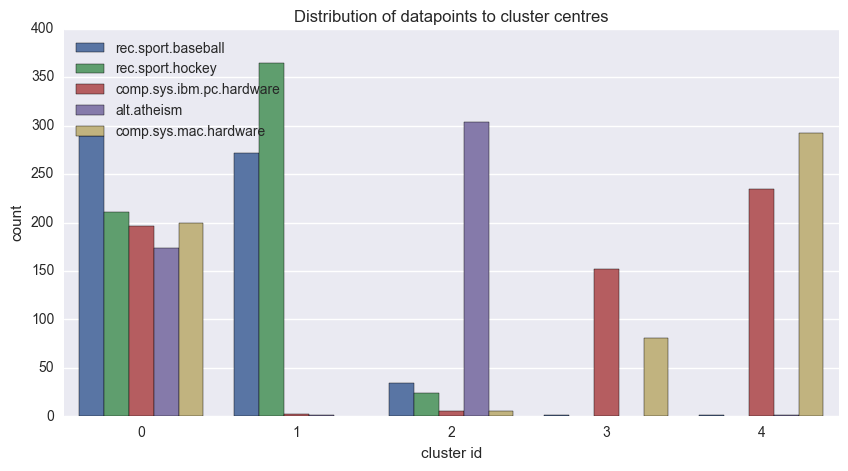

In [9]:
# Your code goes here
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x=kmeans.labels_, hue=y, ax=ax)
plt.title('Distribution of datapoints to cluster centres')
plt.xlabel('cluster id')
plt.show()

*Your answers goes here*  
The quality of the fit is not good. There are too many datapoints equaled 0. and most datapoints in cluster 4 are 'alt.atheism'

### ========== Question 1.7 ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

n_components = 1 interia: 2.82199065984 adjusted rand score: 0.210101502256
n_components = 2 interia: 10.59329323 adjusted rand score: 0.268194567638
n_components = 3 interia: 20.4233010148 adjusted rand score: 0.238732152267
n_components = 5 interia: 49.8679237709 adjusted rand score: 0.223425585583
n_components = 10 interia: 118.179759499 adjusted rand score: 0.217701953337
n_components = 20 interia: 231.926428725 adjusted rand score: 0.206239296724
n_components = 50 interia: 492.330450662 adjusted rand score: 0.214539950219
n_components = 100 interia: 820.117001173 adjusted rand score: 0.211852614456
n_components = 500 interia: 2143.57174637 adjusted rand score: 0.21748257219
n_components = 1000 interia: 2593.11753923 adjusted rand score: 0.222758081101


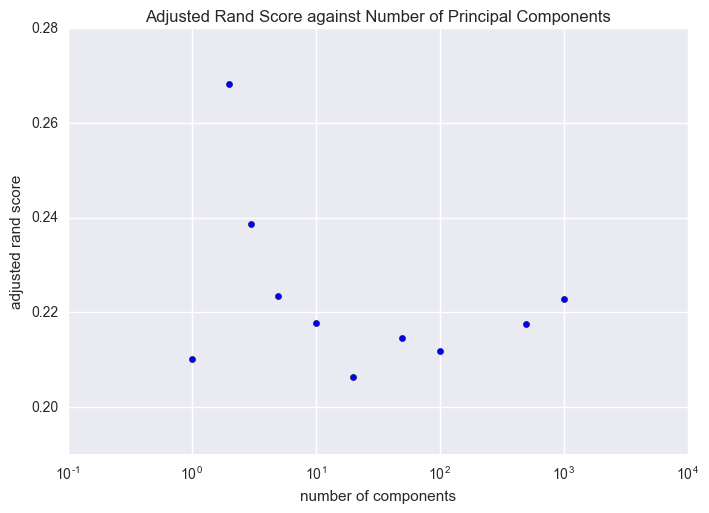

In [10]:
# Your code goes here
n_components = [1,2,3,5,10,20,50,100,500,1000]
result = []
for n in xrange(len(n_components)):
    pca = PCA(n_components=n_components[n])
    X_new = pca.fit_transform(X)
    kmeans_pca = KMeans(n_clusters=5, random_state=0).fit(X_new)
    print("n_components = {0} interia: {1} adjusted rand score: {2}".format(n_components[n], kmeans_pca.inertia_, adjusted_rand_score(y, kmeans_pca.labels_)))
    result.append(adjusted_rand_score(y, kmeans_pca.labels_))

fig = plt.figure()
ax = plt.gca()
ax.scatter(n_components, result, c='blue')
plt.xlabel('number of components')
plt.ylabel('adjusted rand score')
plt.title('Adjusted Rand Score against Number of Principal Components')
ax.set_xscale('log')
plt.show()

*Your answer goes here*
When n_components = 2, it will get the best results, while the penultimate point is the second best point. According to the graph we could see that if we reduce the number of different attributes, we may get a better result. Inertia not only affects the performance of k-means, but also the number of features. The inertia increases with the increase of the number of principal components, and has no significant relation with the adjusted rand score.

### ========== Question 1.8 ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

adjusted rand score: 0.268194567638


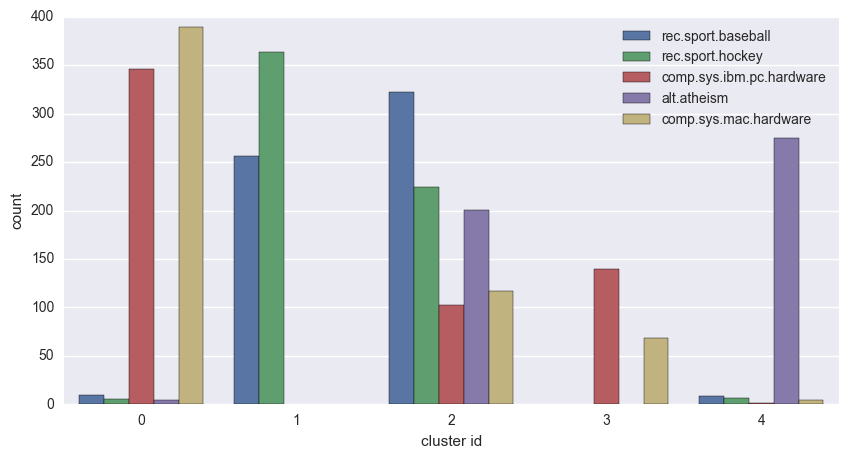

The number of datapoints assigned to each cluster: {0: 754, 1: 620, 2: 967, 3: 208, 4: 296}


In [11]:
# Your code goes here
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
kmeans_pca = KMeans(n_clusters=5, random_state=0).fit(X_2d)
print("adjusted rand score: {0}".format(adjusted_rand_score(y, kmeans_pca.labels_)))

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x=kmeans_pca.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.show()

labels = kmeans_pca.labels_
cluster_num = {}
for m in xrange(len(labels)):
    if labels[m] in cluster_num:
        cluster_num[labels[m]] += 1
    else:
        cluster_num[labels[m]] = 1 
print ("The number of datapoints assigned to each cluster: {0}".format(cluster_num))

*Your answer goes here*  
Yes. Because the adjusted rand index of the model is high. In addition, the distribution is more balanced than before.

### ========== Question 1.9 ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

In [12]:
# Your code goes here
labels_interp  = np.array(cats)[kmeans_pca.labels_]
print (kmeans_pca.labels_)
print (labels_interp)

[2 1 1 ..., 3 1 2]
['comp.sys.mac.hardware' 'comp.sys.ibm.pc.hardware'
 'comp.sys.ibm.pc.hardware' ..., 'rec.sport.baseball'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware']


### ========== Question 1.10 ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

/Users/Meteor/anaconda/envs/iaml/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


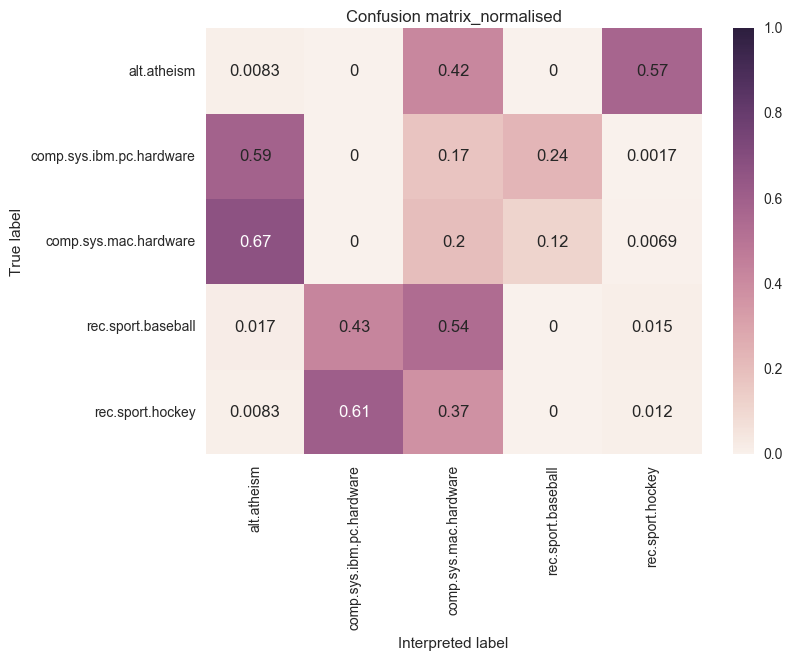

In [13]:
# Your code goes here
cm = confusion_matrix(y, labels_interp)
cm_norm = normalize(cm, norm = 'l1')
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)   #show the title and the name of x,y axis
    plt.ylabel('True label')
    plt.xlabel('Interpreted label')
plot_confusion_matrix(cm_norm, classes = cats, title='Confusion matrix_normalised')
plt.show()

### ========== Question 1.11 ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

explained variance ratio: [ 0.01428699  0.00904075]


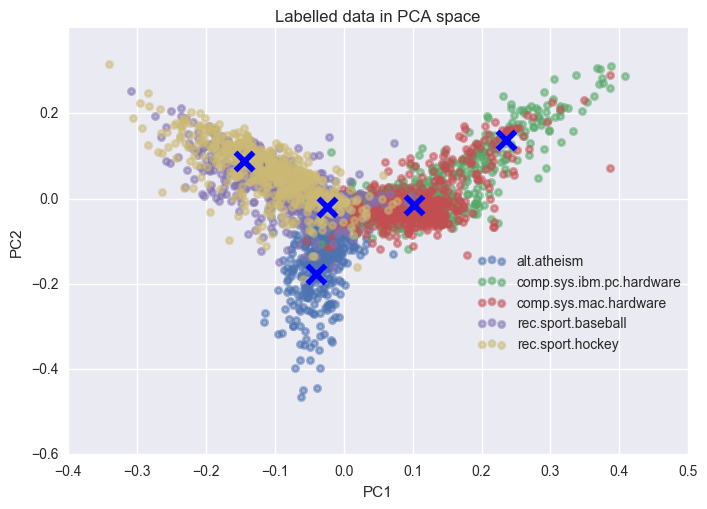

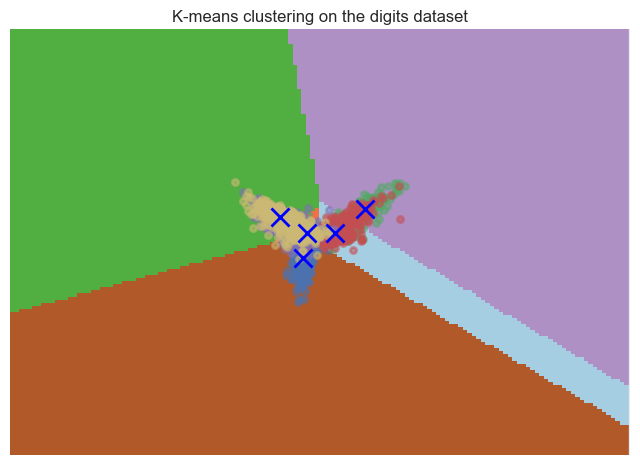

In [15]:
# Your code goes here
print('explained variance ratio: %s'% str(pca.explained_variance_ratio_))
plt.figure(1)
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
cats2 = [c for c in cats]
for color, target_name in zip(colors, cats2):
    plt.scatter(X_2d[y == target_name, 0], X_2d[y == target_name, 1], color=color, alpha=.5, lw=2,
                label=target_name)
centers = kmeans_pca.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],marker='x',s=169, linewidths=4,color='b', zorder=10)
plt.legend(loc='best', scatterpoints=3, bbox_to_anchor=[1.01, 0.5])
plt.title('Labelled data in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
top_plot = plt.gca()
plt.show()


x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
x2, y2 = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
pre = kmeans_pca.predict(np.c_[x2.ravel(), y2.ravel()])
centers = kmeans.cluster_centers_
pre = pre.reshape(x2.shape)
plt.figure(1)
plt.clf()
plt.imshow(pre, interpolation='nearest',
           extent=(x2.min(), x2.max(), y2.min(), y2.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
cats2 = [c for c in cats]
for color, target_name in zip(colors, cats2):
    plt.scatter(X_2d[y == target_name, 0], X_2d[y == target_name, 1], color=color, alpha=.5, lw=2,
                label=target_name)
centers = kmeans_pca.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],marker='x',s=169, linewidths=2,color='b', zorder=10)
plt.title('K-means clustering on the digits dataset')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### ========== Question 1.12  ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.2 (fitting k-means) do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

*Your answer goes here*  
1. No because it depends on the initial center point selection, and if the initial points are good, then the results will be good, otherwise they will be bad. 
2. Yes. Because the default n_init = 10, it will initially group 10 different center points, and then find the best one as the final center point. 
3. random selection. The problem with this method is too unstable. It can choose good center, but it also selects dead pixels, which will lead to undesirable results.

## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [16]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. Print the max/min values for each dimension
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

           0            1            2            3            4   \
count  1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean      0.0     0.303840     5.204786    11.835838    11.848080   
std       0.0     0.907192     4.754826     4.248842     4.287388   
min       0.0     0.000000     0.000000     0.000000     0.000000   
25%       0.0     0.000000     1.000000    10.000000    10.000000   
50%       0.0     0.000000     4.000000    13.000000    13.000000   
75%       0.0     0.000000     9.000000    15.000000    15.000000   
max       0.0     8.000000    16.000000    16.000000    16.000000   

                5            6            7            8            9   \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000   
mean      5.781859     1.362270     0.129661     0.005565     1.993879   
std       5.666418     3.325775     1.037383     0.094222     3.196160   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     

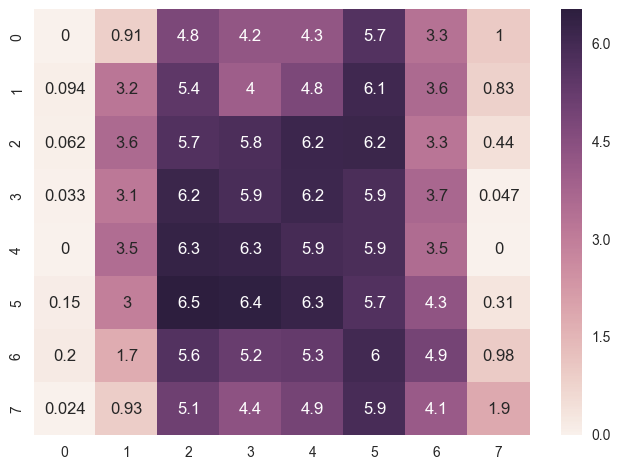

The heatmaps for first 9 digits


NameError: name 'it' is not defined

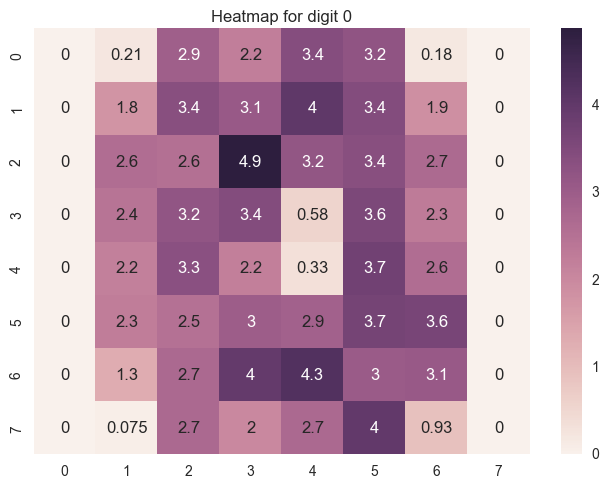

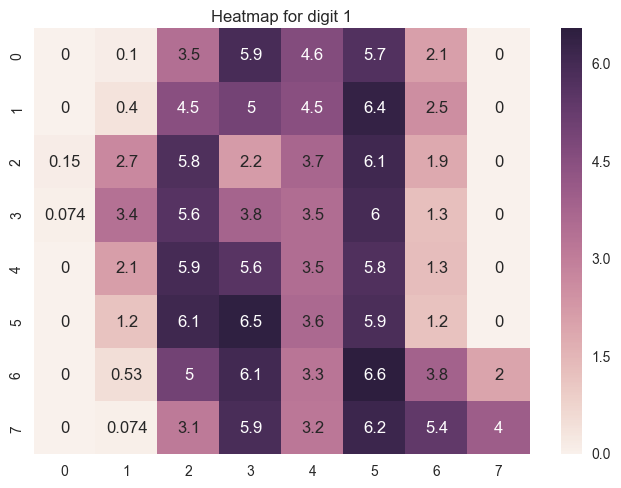

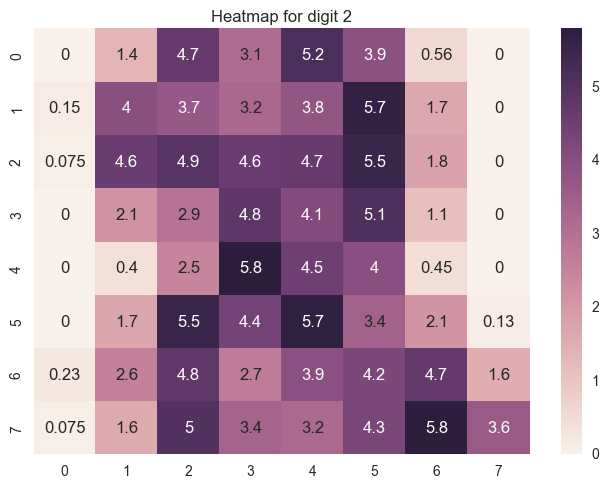

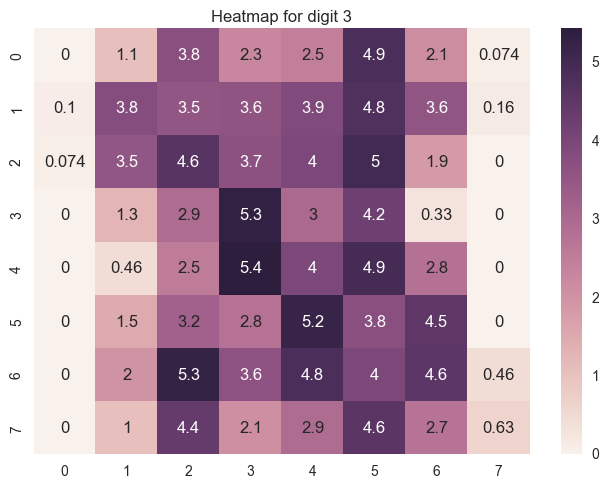

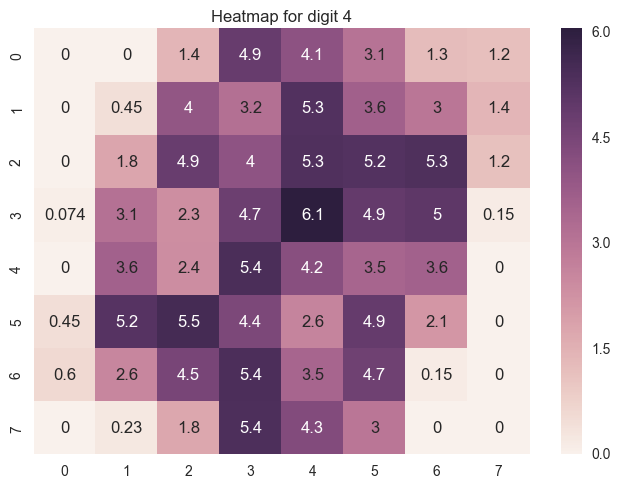

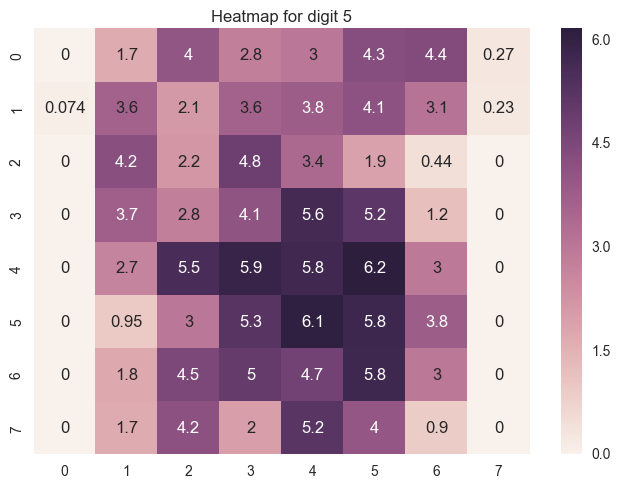

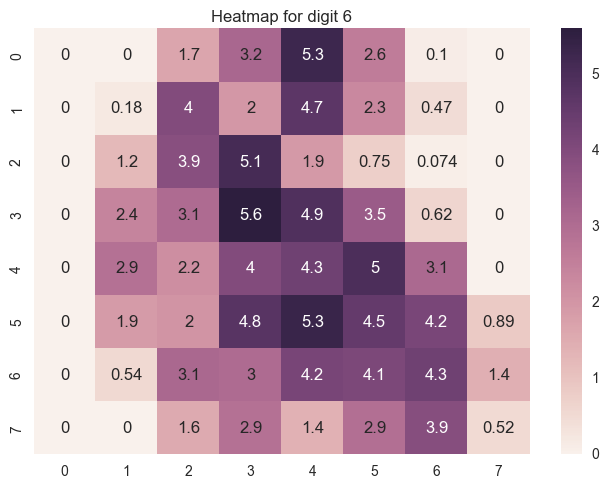

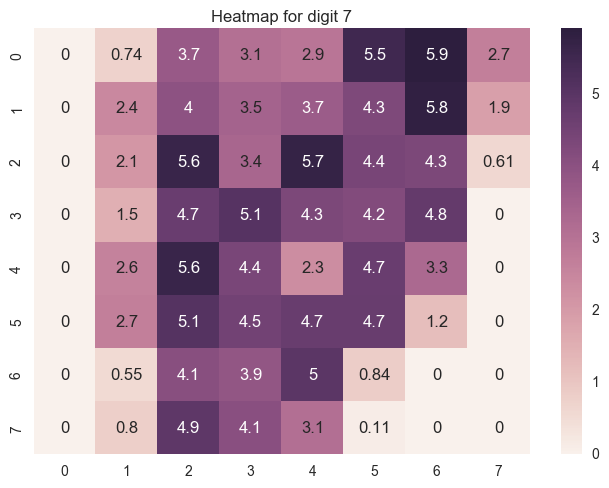

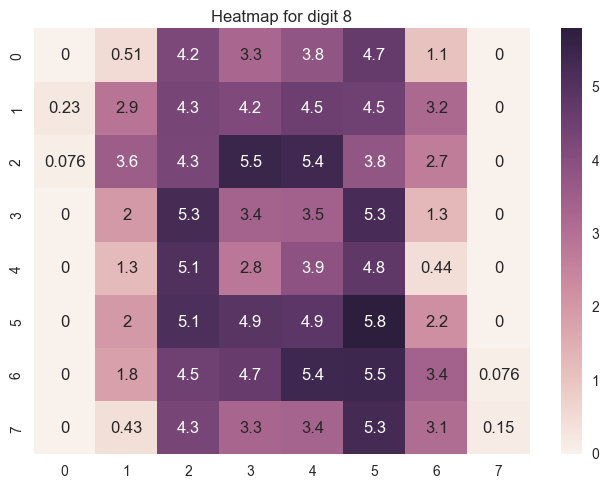

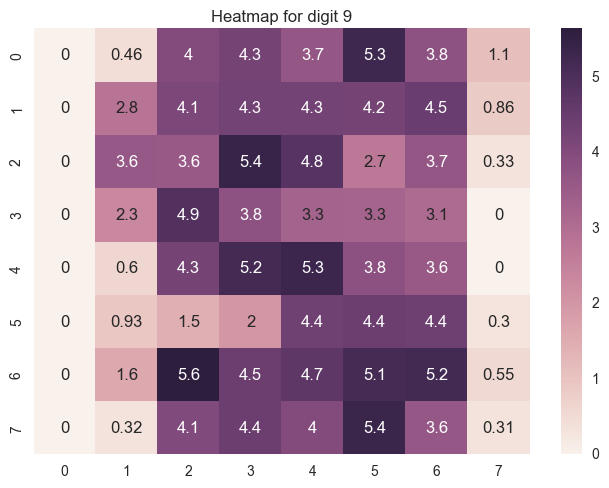

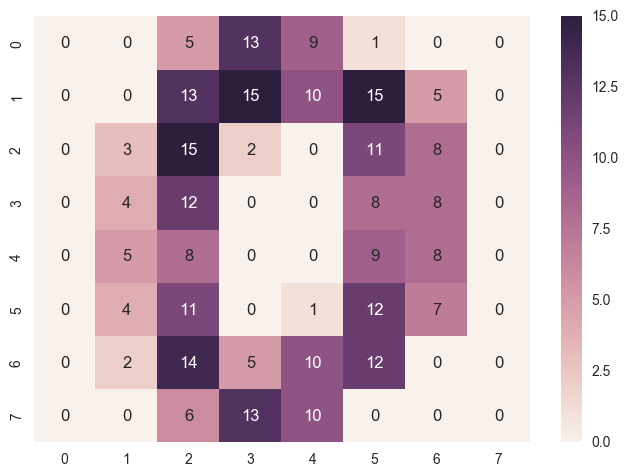

In [17]:
# Your code goes here
df = pd.DataFrame(data = digits.data)
print(df.describe())
print('the max values for each dimension is:{} '.format(df.describe().loc['max']))
print('the min values for each dimension is:{} '.format(df.describe().loc['min']))
print('Print the standard deviations are: {}'. format(df.std()))

std = df.describe().loc['std']
std = std.reshape(8, 8)
fig = sns.heatmap(std,annot=True)
plt.show()

dfg = df.groupby(digits.target)
for dig in range(10):
    fig,ax=plt.subplots()
    stds=dfg.get_group(dig).std()
    stds=stds.reshape(8,8)
    sns.heatmap(stds,annot=True)
    ax.set_title("Heatmap for digit "+str(dig))

print("The heatmaps for first 9 digits")
for n in range(9):
    fig,ax=plt.subplots()
    img=digits.images[n]
    sns.heatmap(img,annot=True)
    ax.set_title("Heatmap for "+str(it)+'th digit (first 9 digits)')

*Your answer goes here*  
No, in the heatmap thare are two columns is almost all 0( dimensions0, 7), so the dimensions 1-6 offer most of help for modelling

### ========== Question 2.2 ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

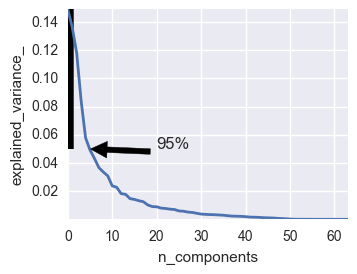

In [18]:
# Your code goes here
pca = PCA(n_components=digits.data.shape[1])
pca.fit(digits.data)

pca.explained_variance_ratio_

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.vlines(x=pca.components_, ymin=0.05, ymax=1)
plt.annotate('95%', xy = (4.3,0.05), xytext = (20, 0.05),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

*Your answer goes here*  
The variance ratio decreases rapidly, when the number of components is small. And when the number of parts becomes large, the deceleration rate becomes slow. 

### ========== Question 2.3 ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

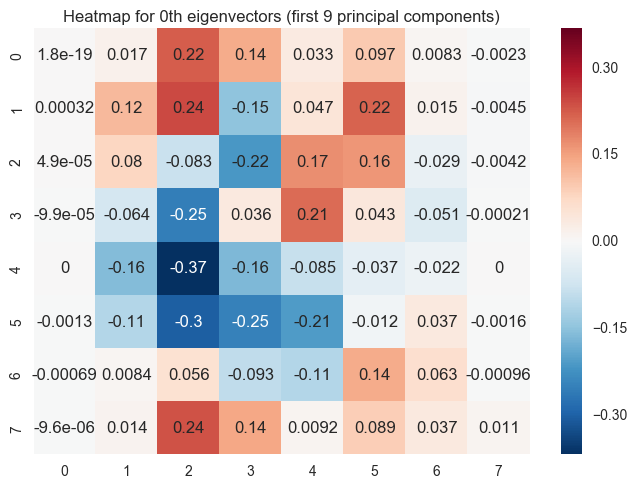

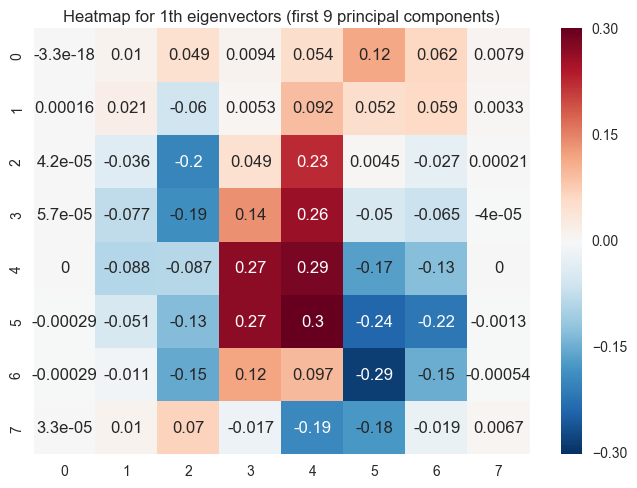

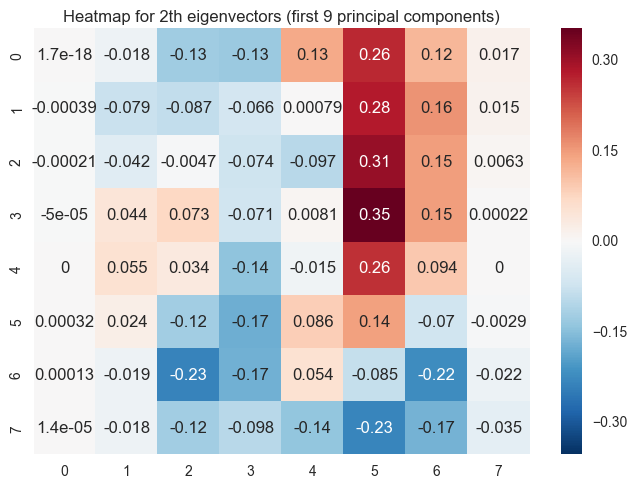

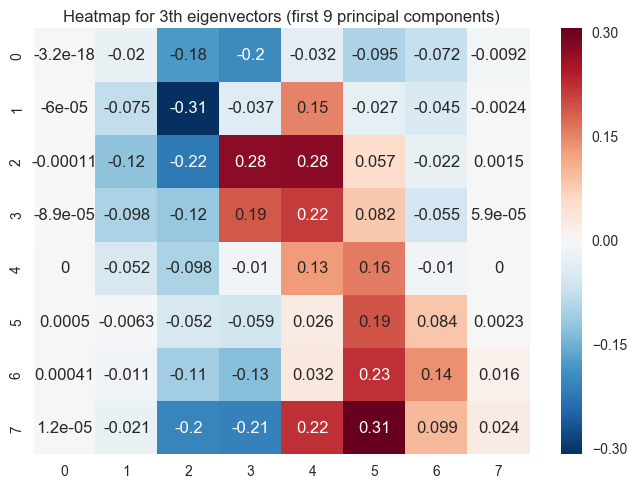

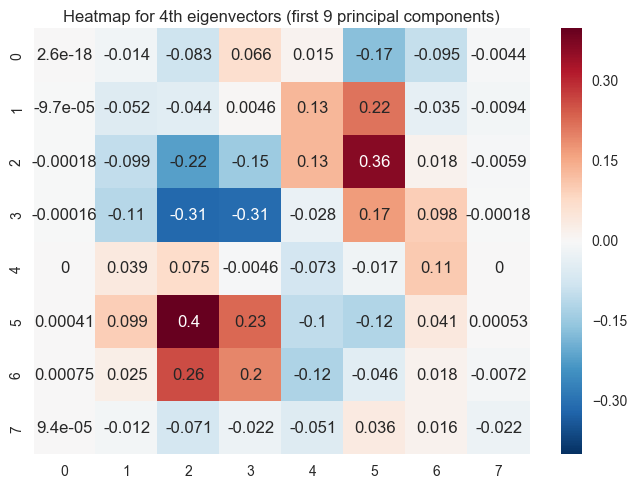

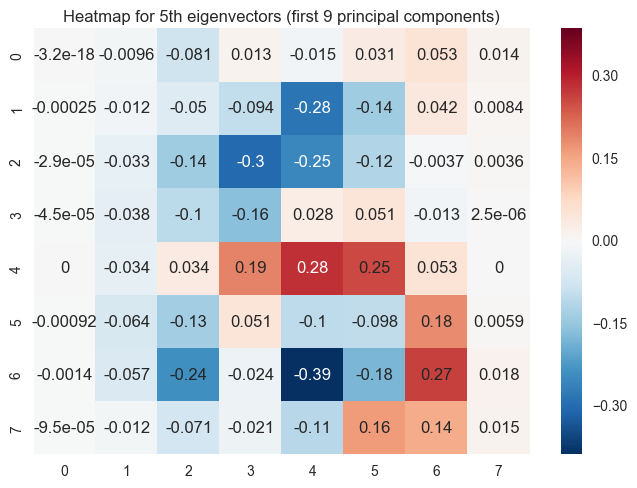

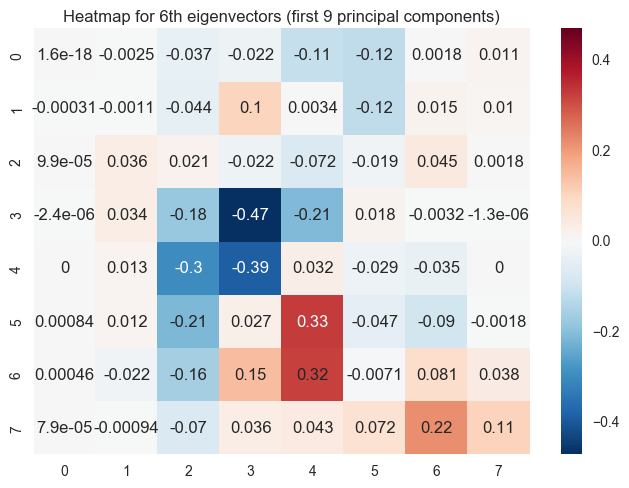

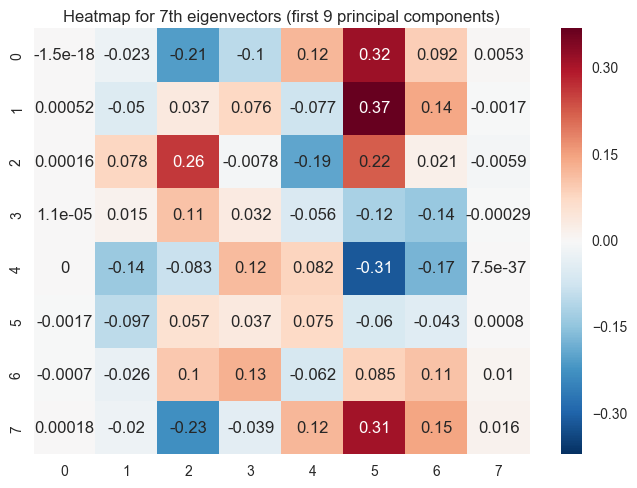

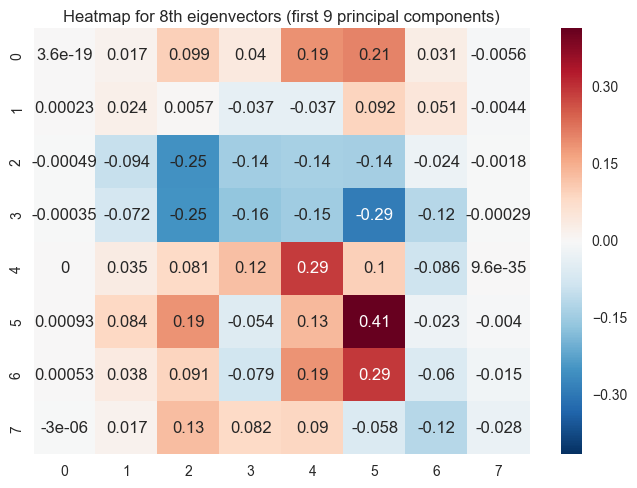

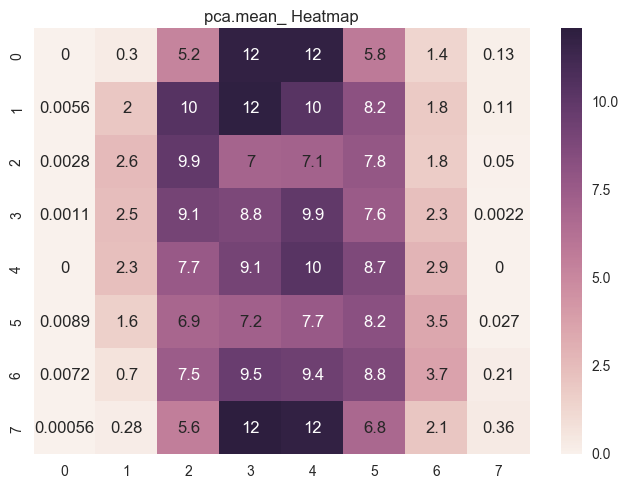

In [19]:
# Your code goes here
for n in range(9):
    fig,ax=plt.subplots()
    temp=pca.components_[n]#64*64, for each one, which should reshape to 8*8
    temp=temp.reshape(8,8)
    sns.heatmap(temp,annot=True)
    ax.set_title("Heatmap for "+str(n)+'th eigenvectors (first 9 principal components)')
    
fig,ax=plt.subplots()
temp=pca.mean_.reshape(8,8)
sns.heatmap(temp,annot=True)
ax.set_title("pca.mean_ Heatmap")
plt.show()

### ========== Question 2.4 ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

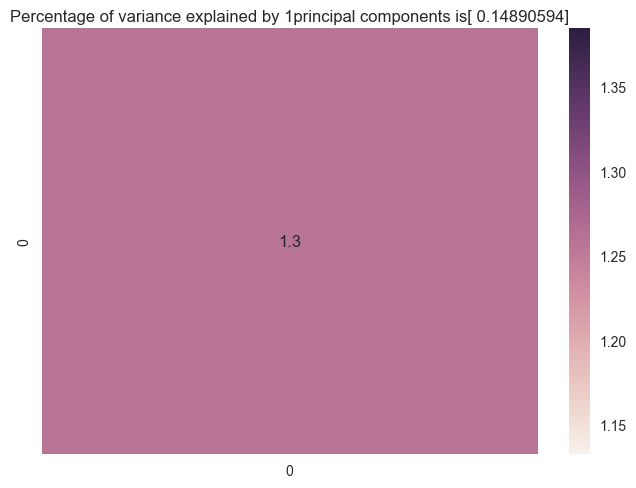

The coefficients of each principal component are [[  1.77484909e-19   1.73094651e-02   2.23428835e-01   1.35913304e-01
    3.30323092e-02   9.66340844e-02   8.32943805e-03  -2.26900082e-03
    3.20516495e-04   1.19308905e-01   2.44451676e-01  -1.48512745e-01
    4.67319410e-02   2.17740744e-01   1.48136776e-02  -4.47779518e-03
    4.94136398e-05   7.95419375e-02  -8.33951454e-02  -2.15915342e-01
    1.72126801e-01   1.63712098e-01  -2.86444452e-02  -4.23251803e-03
   -9.85488574e-05  -6.42319144e-02  -2.54093316e-01   3.56771026e-02
    2.09462569e-01   4.31311420e-02  -5.13118688e-02  -2.13422732e-04
    0.00000000e+00  -1.59950883e-01  -3.68690774e-01  -1.64406827e-01
   -8.52007908e-02  -3.72982855e-02  -2.15866980e-02   0.00000000e+00
   -1.28865585e-03  -1.06945287e-01  -3.03067457e-01  -2.47813041e-01
   -2.09637296e-01  -1.22325219e-02   3.69458497e-02  -1.61485028e-03
   -6.93023548e-04   8.35144239e-03   5.58598986e-02  -9.30534169e-02
   -1.07387720e-01   1.37734565e-01   6.3

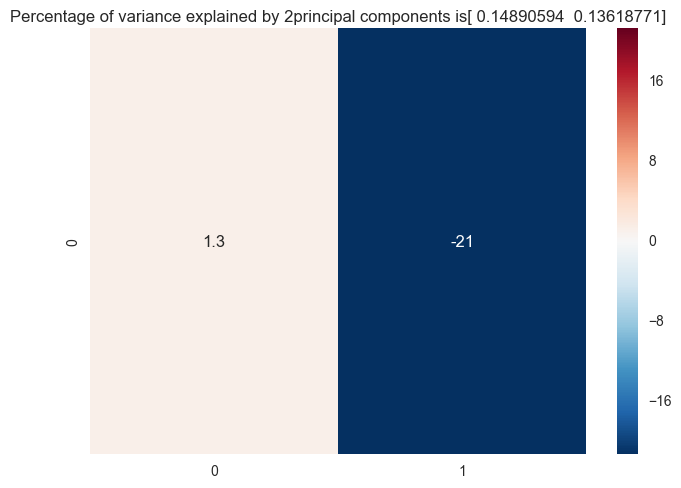

The coefficients of each principal component are [[  1.77484909e-19   1.73094651e-02   2.23428835e-01   1.35913304e-01
    3.30323092e-02   9.66340844e-02   8.32943805e-03  -2.26900082e-03
    3.20516495e-04   1.19308905e-01   2.44451676e-01  -1.48512745e-01
    4.67319410e-02   2.17740744e-01   1.48136776e-02  -4.47779518e-03
    4.94136398e-05   7.95419375e-02  -8.33951454e-02  -2.15915342e-01
    1.72126801e-01   1.63712098e-01  -2.86444452e-02  -4.23251803e-03
   -9.85488574e-05  -6.42319144e-02  -2.54093316e-01   3.56771026e-02
    2.09462569e-01   4.31311420e-02  -5.13118688e-02  -2.13422732e-04
    0.00000000e+00  -1.59950883e-01  -3.68690774e-01  -1.64406827e-01
   -8.52007908e-02  -3.72982855e-02  -2.15866980e-02   0.00000000e+00
   -1.28865585e-03  -1.06945287e-01  -3.03067457e-01  -2.47813041e-01
   -2.09637296e-01  -1.22325219e-02   3.69458497e-02  -1.61485028e-03
   -6.93023548e-04   8.35144239e-03   5.58598986e-02  -9.30534169e-02
   -1.07387720e-01   1.37734565e-01   6.3

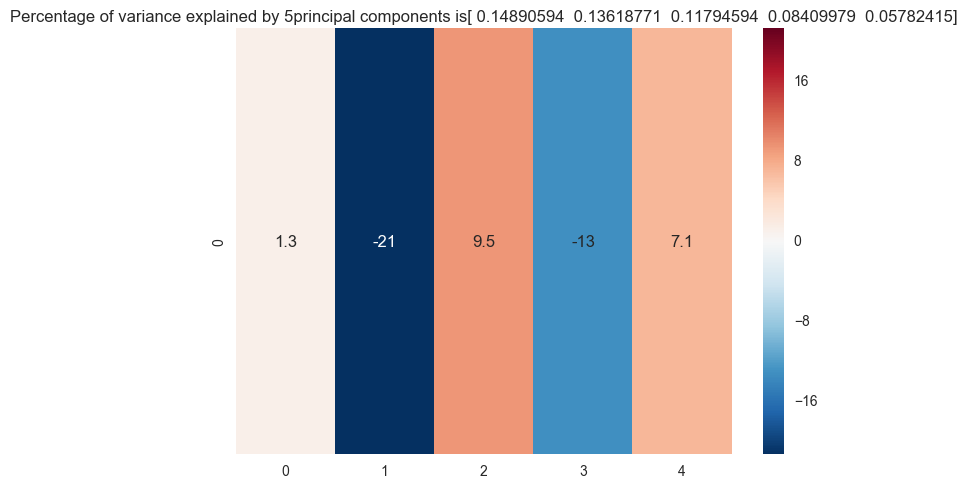

The coefficients of each principal component are [[  1.77484909e-19   1.73094651e-02   2.23428835e-01   1.35913304e-01
    3.30323092e-02   9.66340844e-02   8.32943805e-03  -2.26900082e-03
    3.20516495e-04   1.19308905e-01   2.44451676e-01  -1.48512745e-01
    4.67319410e-02   2.17740744e-01   1.48136776e-02  -4.47779518e-03
    4.94136398e-05   7.95419375e-02  -8.33951454e-02  -2.15915342e-01
    1.72126801e-01   1.63712098e-01  -2.86444452e-02  -4.23251803e-03
   -9.85488574e-05  -6.42319144e-02  -2.54093316e-01   3.56771026e-02
    2.09462569e-01   4.31311420e-02  -5.13118688e-02  -2.13422732e-04
    0.00000000e+00  -1.59950883e-01  -3.68690774e-01  -1.64406827e-01
   -8.52007908e-02  -3.72982855e-02  -2.15866980e-02   0.00000000e+00
   -1.28865585e-03  -1.06945287e-01  -3.03067457e-01  -2.47813041e-01
   -2.09637296e-01  -1.22325219e-02   3.69458497e-02  -1.61485028e-03
   -6.93023548e-04   8.35144239e-03   5.58598986e-02  -9.30534169e-02
   -1.07387720e-01   1.37734565e-01   6.3

In [20]:
# Your code goes here
n_components=[1,2,5]
idx=0
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(digits.data)
    digits_p=pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()
    fig,ax=plt.subplots()
    temp=digits_p.reshape(1,n)
    sns.heatmap(temp,annot=True)
    ax.set_title('Percentage of variance explained by '+str(n)+"principal components is"+str(pca.explained_variance_ratio_))
    plt.show()
    print('The coefficients of each principal component are {}'.format(pca.components_))



*Your answer goes here*  
No. The variance percentage of the different interpretations and the coefficients of each principal component are the same in different graphs

### ========== Question 2.5 ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved but the other did not!

In [21]:
# Your code goes here
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

kf = KFold(digits.data.shape[0], n_folds=5, shuffle=True, random_state=0)
pca = PCA(n_components=digits.data.shape[1])
pca.fit(digits.data)
X_pca=pca.transform(digits.data)

svc = SVC(kernel='linear', random_state=1) 
svc.fit(digits.data, digits.target)
score_svc=cross_val_score(svc, digits.data, digits.target, cv=kf)

svc = SVC(kernel='linear', random_state=1) 
svc.fit(X_pca, digits.target)
score_svc_pca=cross_val_score(svc, X_pca, digits.target, cv=kf)

gnb = GaussianNB()
gnb.fit(digits.data, digits.target)

score_gnb=cross_val_score(gnb, digits.data, digits.target, cv=kf)

gnb = GaussianNB()
gnb.fit(X_pca, digits.target)
score_gnb_pca=cross_val_score(gnb, X_pca, digits.target, cv=kf)

print(np.mean(score_svc))
print(np.mean(score_svc_pca))
print(np.mean(score_gnb))
print(np.mean(score_gnb_pca))



0.984422779325
0.984422779325
0.833611884865
0.88872175797


*Your answer goes here*  
SVM uses the suppot vector to construct the model. The pca transform does not affect the choice of support vectors, so the results are not affected.
Since the GaussianNB will perform better on continuous data than on discrete data, the data becomes continuous after the pca transform, and the Gaussian NB will have an improvement.